### Imports + load data

In [22]:
import sys
print(sys.executable)

/opt/anaconda3/envs/hmfc/bin/python


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.stats import norm, ttest_ind
from scipy.optimize import minimize

per = pd.read_csv("Data/PerceptualTaskData.csv")      
sym = pd.read_csv("Data/SymptomData.csv")          

per.head(), sym.head()

(    IDcode  Age  Sex  Trial  Response  Stimulus  Confidence
 0  4676165   67    1      1         0        16           1
 1  4676165   67    1      2         0         8           2
 2  4676165   67    1      3         1        56           3
 3  4676165   67    1      4         1        32           3
 4  4676165   67    1      5         0        48           3,
     IDcode  Age  Sex  AnxiousDepression  Compulsivity  SocialWithdrawal
 0  4676165   67    1           0.997218     -1.174643          0.503585
 1  4676332   28    1          -0.488935     -1.178822          0.197481
 2  4676373   19    1          -1.180051     -1.219396         -1.101509
 3  4676552   24    1          -0.280664     -0.475714         -0.558212
 4  4676560   34    1           2.167959      1.647215          0.403726)

## Helper code

In [24]:
def mean_sem(x):
    x = x.dropna()
    return x.mean(), x.std(ddof=1) / np.sqrt(len(x))

def stars(p):
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return "n.s."

## D' and criterion c

In [25]:
def loglinear_rate(k,n):
    # Hit and false-alarm rates were corrected using the log-linear rule (Hautus, 1995) to avoid infinite z-scores when proportions equalled 0 or 1.
    return (k + 0.5)/(n + 1)

def compute_dprime_c (stim, resp):
    # stim: signed stimulus, resp: 0/1. We take right as the hit
    sig = stim > 0
    noise = stim < 0

    # Stimulus == 0 can be ignored for SDT rates
    H = resp[sig].sum()
    FA = resp[noise].sum()

    hr  = loglinear_rate(H, sig.sum())
    far = loglinear_rate(FA, noise.sum())

    zH = norm.ppf(hr)
    zF = norm.ppf(far)

    dprime = zH - zF
    c = -0.5 * (zH + zF)
    return dprime, c


## Meta-d' helper function

In [26]:
# Had some help of AI
def counts_for_subject(df, K=6):
    df = df[df["Stimulus"] != 0].copy()
    stim = df["Stimulus"].values
    resp = df["Response"].values
    conf = df["Confidence"].values

    cat = np.empty(len(df), dtype=int)

    # resp=0 => S1 (lef) response: map conf=6 to cat=1 (high), conf=1 naar cat=K (low)
    m0 = resp == 0
    cat[m0] = K - conf[m0] + 1

    # resp=1 => S2 (right) response: map conf=1 to cat=K+1 (low), conf=6 to cat=2K (low)
    m1 = ~m0
    cat[m1] = K + conf[m1]

    S1 = stim < 0
    S2 = stim > 0

    nR_S1 = np.array([(cat[S1] == i).sum() for i in range(1, 2*K + 1)])
    nR_S2 = np.array([(cat[S2] == i).sum() for i in range(1, 2*K + 1)])
    return nR_S1, nR_S2

## Likelihood + optimizer

In [27]:
def metad_negloglik(params, nR_S1, nR_S2, c, K): #Had some help of AI
    meta_d = params[0]

    # enforce monotonically ordered criteria via cumulative positive steps
    s1_steps = np.exp(params[1:K])         # K-1
    s2_steps = np.exp(params[K:2*K-1])     # K-1

    # criteria on evidence axis
    s1_crit = np.sort(c - np.cumsum(s1_steps))  # below c
    s2_crit = np.sort(c + np.cumsum(s2_steps))  # above c

    muS1 = -meta_d / 2
    muS2 =  meta_d / 2

    # Edges for S1 response bins: (-inf ... s1_crit ... c)
    s1_edges = np.concatenate(([-np.inf], s1_crit, [c]))
    # S1-response category probs for a given mu:
    def p_respS1(mu):
        p = norm.cdf(s1_edges[1:], loc=mu) - norm.cdf(s1_edges[:-1], loc=mu)
        return p[::-1]  #  high->low confidence within S1 responses

    # Edges for S2 response bins: (c ... s2_crit ... inf)
    s2_edges = np.concatenate(([c], s2_crit, [np.inf]))
    def p_respS2(mu):
        return norm.cdf(s2_edges[1:], loc=mu) - norm.cdf(s2_edges[:-1], loc=mu)  # low->high within S2 responses

    pS1 = np.concatenate((p_respS1(muS1), p_respS2(muS1)))
    pS2 = np.concatenate((p_respS1(muS2), p_respS2(muS2)))

    eps = 1e-12
    ll = (nR_S1 * np.log(pS1 + eps)).sum() + (nR_S2 * np.log(pS2 + eps)).sum()
    return -ll

def fit_metad(nR_S1, nR_S2, c, K=6): #Had some help of AI
    init = np.zeros(1 + 2*(K-1))
    init[0] = 1
    init[1:] = np.log(0.5)

    bounds = [(1e-3, 6.0)] + [(-5, 5)]*(2*(K-1))

    res = minimize(
        metad_negloglik,
        init,
        args=(nR_S1, nR_S2, c, K),
        method="L-BFGS-B",
        bounds=bounds,
        options={"maxiter": 200}  
    )
    if not res.success:
        return np.nan, None, None, False

    params = res.x
    meta_d = params[0]

    s1_steps = np.exp(params[1:K])
    s2_steps = np.exp(params[K:2*K-1])
    s1_crit = c - np.cumsum(s1_steps)
    s2_crit = c + np.cumsum(s2_steps)

    return meta_d, s1_crit, s2_crit, True

def confidence_criterion_from_criteria(c, s1_crit, s2_crit):
    """
    Benwell-style: |type2_c' - type1_c'| averaged over response sides & criteria.
    Here we approximate type1_c' by c (your SDT criterion) and type2 criteria by the fitted criteria locations.
    Larger value = more conservative / lower confidence bias.
    """
    dist_s1 = np.abs(s1_crit - c)  # K-1
    dist_s2 = np.abs(s2_crit - c)  # K-1
    return np.mean(np.concatenate([dist_s1, dist_s2]))

## D', meta-d', mean confidence merging with symptom dimension

In [28]:
K = 6
rows = []

for pid, dfsub in per.groupby("IDcode"):
    stim = dfsub["Stimulus"].values
    resp = dfsub["Response"].values

    dprime, c = compute_dprime_c(stim, resp)

    nR_S1, nR_S2 = counts_for_subject(dfsub, K = K)
    metad, s1_crit, s2_crit, ok = fit_metad(nR_S1, nR_S2, c, K=K)

    mean_conf = dfsub["Confidence"].mean()

    conf_criterion = np.nan
    if ok and (s1_crit is not None) and (s2_crit is not None):
        conf_criterion = confidence_criterion_from_criteria(c, s1_crit, s2_crit)

    mratio = np.nan
    if ok and np.isfinite(dprime) and (dprime != 0):
        mratio = metad / dprime

    rows.append({
    "IDcode": pid,
    "dprime": dprime,
    "metad": metad if ok else np.nan,
    "mratio": mratio,
    "mean_conf": mean_conf,
    "conf_criterion": conf_criterion
    })

metrics = pd.DataFrame(rows)

df = (
    metrics.merge(
        sym[["IDcode", "Compulsivity", "AnxiousDepression", "SocialWithdrawal", "Age", "Sex"]],
        on="IDcode",
        how="inner"
    )
    .rename(columns={
        "Compulsivity": "CIT",
        "AnxiousDepression": "AD",
        "SocialWithdrawal": "SW",
        "Age": "age",
        "Sex": "gender"
    })
)

# --- Make tertiles again ---
df_comp = df.copy()
df_comp["group"] = pd.qcut(df_comp["CIT"], 3, labels=["low", "mid", "high"])

df_ad = df.copy()
df_ad["group"] = pd.qcut(df_ad["AD"], 3, labels=["low", "mid", "high"])

df_sw = df.copy()
df_sw["group"] = pd.qcut(df_sw["SW"], 3, labels=["low", "mid", "high"])

## Make the barplot

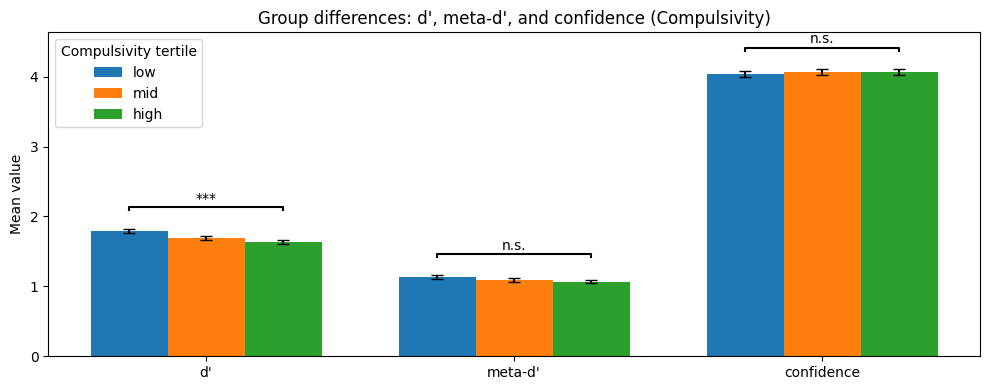

Compulsivity {"d'": (np.float64(0.0001462220894119103), '***'), "meta-d'": (np.float64(0.05426489914840176), 'n.s.'), 'confidence': (np.float64(0.6088944556966358), 'n.s.')}


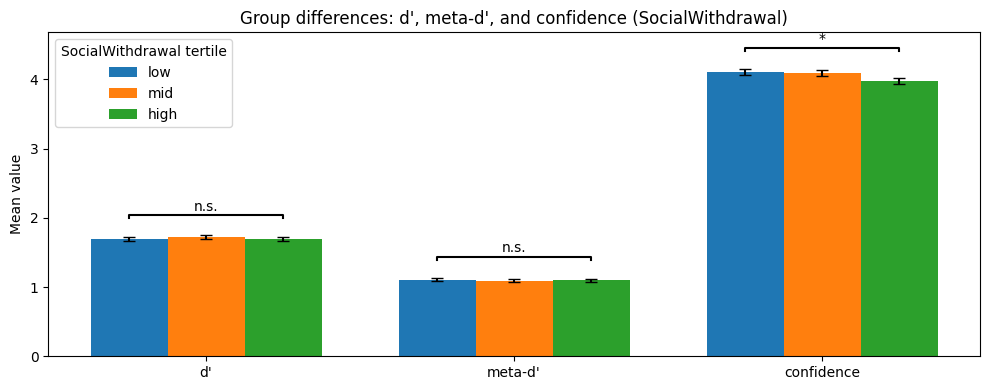

SocialWithdrawal {"d'": (np.float64(0.9549048989071882), 'n.s.'), "meta-d'": (np.float64(0.7018188392027778), 'n.s.'), 'confidence': (np.float64(0.03938662046922962), '*')}


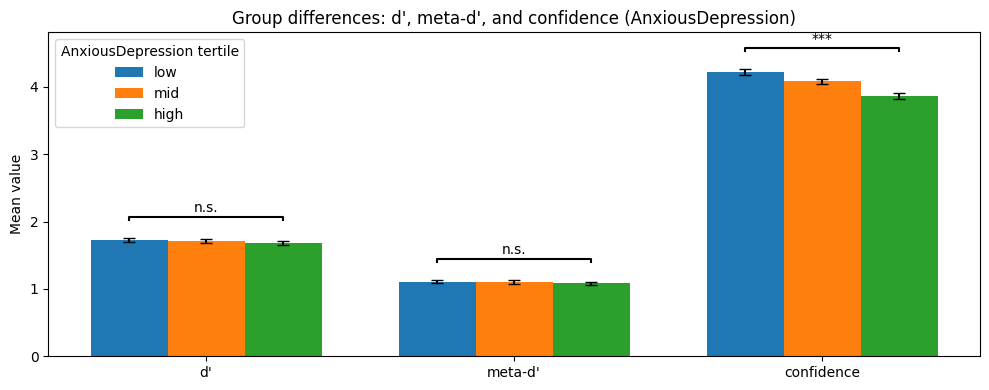

AnxiousDepression {"d'": (np.float64(0.262848355876576), 'n.s.'), "meta-d'": (np.float64(0.4119847349228043), 'n.s.'), 'confidence': (np.float64(2.0637367229758973e-08), '***')}


In [29]:
order = ["low", "mid", "high"]
metrics_to_plot = [("dprime", "d'"), ("metad", "meta-d'"), ("mean_conf", "confidence")]

def plot_tertiles(df, title_suffix, legend_title):
    means = {m: [] for m, _ in metrics_to_plot}
    sems  = {m: [] for m, _ in metrics_to_plot}

    for g in order:
        sub = df[df["group"] == g]
        for m, _ in metrics_to_plot:
            mu, se = mean_sem(sub[m])
            means[m].append(mu)
            sems[m].append(se)

    # significance (high vs low)
    pvals = {}
    for m, _ in metrics_to_plot:
        low_vals  = df[df["group"] == "low"][m].dropna()
        high_vals = df[df["group"] == "high"][m].dropna()
        pvals[m] = ttest_ind(low_vals, high_vals, equal_var=False).pvalue

    # plot
    fig, ax = plt.subplots(figsize=(10, 4))
    x = np.arange(len(metrics_to_plot))
    w = 0.25

    colors = ["tab:blue", "tab:orange", "tab:green"]
    for i, g in enumerate(order):
        vals = [means[m][i] for m, _ in metrics_to_plot]
        err  = [sems[m][i]  for m, _ in metrics_to_plot]
        ax.bar(x + (i-1)*w, vals, width=w, yerr=err, capsize=4,
               color=colors[i], label=g)

    ax.set_xticks(x)
    ax.set_xticklabels([lab for _, lab in metrics_to_plot])
    ax.set_ylabel("Mean value")
    ax.set_title(f"Group differences: d', meta-d', and confidence ({title_suffix})")

    # add stars (low vs high)
    y0, y1 = ax.get_ylim()
    yr = y1 - y0
    for j, (m, _) in enumerate(metrics_to_plot):
        y_max = max(means[m][0] + sems[m][0], means[m][2] + sems[m][2])
        y = y_max + 0.06*yr
        x1 = j - w
        x2 = j + w
        ax.plot([x1, x1, x2, x2], [y, y+0.01*yr, y+0.01*yr, y], lw=1.5, c="black")
        ax.text((x1+x2)/2, y+0.015*yr, stars(pvals[m]), ha="center", va="bottom")

    ax.legend(title=legend_title)
    plt.tight_layout()
    plt.show()

    print(title_suffix, {lab: (pvals[m], stars(pvals[m])) for m, lab in metrics_to_plot})

plot_tertiles(df_comp, "Compulsivity", "Compulsivity tertile")
plot_tertiles(df_sw, "SocialWithdrawal", "SocialWithdrawal tertile")
plot_tertiles(df_ad, "AnxiousDepression", "AnxiousDepression tertile")

## Benwell-style figure


DV: dprime
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1328      0.039     -3.376      0.001      -0.210      -0.056
CIT           -0.1746      0.035     -4.967      0.000      -0.244      -0.106
AD             0.0108      0.036      0.302      0.763      -0.059       0.081
SW             0.0977      0.035      2.820      0.005       0.030       0.166
age           -0.0491      0.032     -1.543      0.123      -0.112       0.013
gender         0.3095      0.061      5.100      0.000       0.190       0.429

DV: metad
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0538      0.040     -1.346      0.179      -0.132       0.025
CIT           -0.1309      0.036     -3.661      0.000      -0.201      -0.061
AD             0.0223      0.

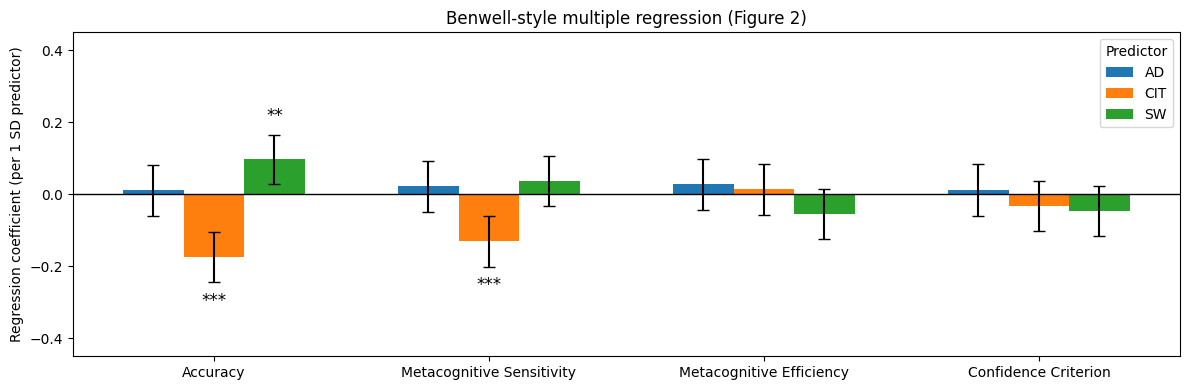

In [30]:
#Ai was used here. First time I did a regression in Python so not sure I did it correctly.
def zscore(s):
    s = s.astype(float)
    return (s - s.mean()) / s.std(ddof=0)

def plot_benwell_fig2(df,
                      dvs=[("dprime","Accuracy"),
                           ("metad","Metacognitive Sensitivity"),
                           ("mratio","Metacognitive Efficiency"),
                           ("conf_criterion","Confidence Criterion")],
                      predictors=("CIT","AD","SW","age","gender"),
                      interest=("AD","CIT","SW"),
                      title="Benwell-style multiple regression (Figure 2)", ylim=(-0.45, 0.45)):
    df = df.copy()

    # z-score regressors (Benwell: z-scores of all regressors)
    for col in ["CIT","AD","SW","age","gender"]:
        if col in df.columns and col != "gender":
            df[col] = zscore(df[col])

    # z-score dependent variables
    for dv, _ in dvs:
        if dv in df.columns:
            df[dv] = zscore(df[dv])

    results = {}  # dv -> term -> (beta, lo, hi)

    for dv, _ in dvs:
        sub = df[[dv] + list(predictors)].dropna().copy()
        if len(sub) < 30:
            print(f"Skip {dv}: too few rows ({len(sub)})")
            continue

        X = sm.add_constant(sub[list(predictors)])
        y = sub[dv].astype(float)

        model = sm.OLS(y, X).fit()
        ci = model.conf_int()

        results[dv] = {}
        for term in interest:
            results[dv][term] = {
                "beta": model.params[term],
                "lo":   ci.loc[term, 0],
                "hi":   ci.loc[term, 1],
                "p":    model.pvalues[term],
            }

        print(f"\nDV: {dv}")
        print(model.summary().tables[1])  # coef table

    dv_keys = [dv for dv, _ in dvs if dv in results]
    labels  = [lab for dv, lab in dvs if dv in results]

    x = np.arange(len(dv_keys))
    w = 0.22
    offsets = {"AD": -w, "CIT": 0.0, "SW": +w}

    fig, ax = plt.subplots(figsize=(12, 4))

    for term in ["AD","CIT","SW"]:
        betas = [results[dv][term]["beta"] for dv in dv_keys]
        los   = [results[dv][term]["lo"]   for dv in dv_keys]
        his   = [results[dv][term]["hi"]   for dv in dv_keys]

        yerr = np.vstack([np.array(betas) - np.array(los),
                          np.array(his) - np.array(betas)])

        ax.bar(x + offsets[term], betas, width=w, yerr=yerr, capsize=4, label=term)

        # add significance stars per bar
        for j, dv in enumerate(dv_keys):
            p = results[dv][term]["p"]
            st = stars(p)
            if st == "n.s.":
                continue

            b  = results[dv][term]["beta"]
            lo = results[dv][term]["lo"]
            hi = results[dv][term]["hi"]

            # place star just beyond the CI in the direction of the bar
            if b >= 0:
                y_text = hi + 0.03 * (ylim[1] - ylim[0])
                va = "bottom"
            else:
                y_text = lo - 0.03 * (ylim[1] - ylim[0])
                va = "top"

            ax.text(j + offsets[term], y_text, st, ha="center", va=va, fontsize=12)

    ax.axhline(0, color="black", lw=1)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Regression coefficient (per 1 SD predictor)")
    ax.set_title(title)
    ax.legend(title="Predictor")
  

    ax.set_ylim(*ylim)
    ax.set_yticks(np.arange(-0.4, 0.41, 0.2))

    plt.tight_layout()
    plt.show()

plot_benwell_fig2(df)